In [ ]:
! git clone https://github.com/mohsenfayyaz/DecompX.git
! pip install datasets

In [1]:
import os
os.chdir('/mounts/Users/cisintern/amodaresi/Projects/Retriever-Contextualization/')
# from dotenv import load_dotenv
from huggingface_hub import login

# load_dotenv()
login(os.environ["HF_TOKEN"])
# print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"], "HF_HOME:", os.environ["HF_HOME"])
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

/mounts/Users/cisintern/amodaresi/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid.
Your token has been saved to /mounts/Users/cisintern/amodaresi/.cache/huggingface/token
Login successful


In [2]:
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, HTML
import transformers
from transformers import AutoTokenizer, AutoConfig

from DecompX.src.decompx_utils import DecompXConfig
from DecompX.src.modeling_bert import BertForSequenceClassification, BertModel
from DecompX.src.modeling_roberta import RobertaForSequenceClassification, RobertaModel

df = pd.read_parquet("hf://datasets/Retriever-Contextualization/datasets/nq/facebook--contriever-msmarco_corpus4201.parquet")
df

,key,query,gold_docs,gold_docs_text,results,predicted_docs_text_5
0,test0,what is non controlling interest on balance sheet,"[doc0, doc1]","[{'text': 'In accounting, minority interest (o...","{'doc0': 0.6976444125175476, 'doc1': 0.6396650...","[{'text': 'In accounting, minority interest (o..."
1,test1,how many episodes are in chicago fire season 4,[doc6],"[{'text': 'The fourth season of Chicago Fire, ...","{'doc0': None, 'doc1': None, 'doc10': 0.277735...","[{'text': 'The fourth season of Chicago Fire, ..."
2,test2,who sings love will keep us alive by the eagles,[doc10],"[{'text': '""Love Will Keep Us Alive"" is a song...","{'doc0': None, 'doc1': None, 'doc10': 0.793368...","[{'text': '""Love Will Keep Us Alive"" is a song..."
3,test3,who is the leader of the ontario pc party,"[doc17, doc18]",[{'text': 'Patrick Walter Brown MPP (born May ...,"{'doc0': None, 'doc1': None, 'doc10': None, 'd...","[{'text': 'In May 2015, Brown was elected lead..."
4,test4,nitty gritty dirt band fishin in the dark album,[doc42],"[{'text': '""Fishin' in the Dark"" is a song wri...","{'doc0': None, 'doc1': None, 'doc10': 0.337679...","[{'text': '""Fishin' in the Dark"" is a song wri..."
...,...,...,...,...,...,...
3447,test3447,when is the met office leaving the bbc,[doc117531],"[{'text': 'On 23 August 2015, the BBC announce...","{'doc0': None, 'doc1': None, 'doc10': 0.277022...","[{'text': 'On 23 August 2015, the BBC announce..."
3448,test3448,where does junior want to go to find hope,[doc117567],"[{'text': 'Throughout the novel, Junior shares...","{'doc0': None, 'doc1': None, 'doc10': None, 'd...","[{'text': 'Throughout the novel, Junior shares..."
3449,test3449,who does eric end up with in that 70s show,"[doc117643, doc117646]","[{'text': 'Regretting it instantly, Eric goes ...","{'doc0': None, 'doc1': None, 'doc10': 0.312646...",[{'text': 'Due to Eric's departure from the sh...
3450,test3450,where does the great outdoors movie take place,"[doc117662, doc117663]",[{'text': 'The film follows two families spend...,"{'doc0': None, 'doc1': None, 'doc10': None, 'd...",[{'text': 'The film follows two families spend...


In [3]:
DATASET = df.attrs["dataset"]
MODEL = df.attrs["model"]  # 'facebook/contriever-msmarco'  # Only BERT or RoBERTa
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CONFIGS = {
    "DecompX":
        DecompXConfig(
            include_biases=True,
            bias_decomp_type="absdot",
            include_LN1=True,
            include_FFN=True,
            FFN_approx_type="GeLU_ZO",
            include_LN2=True,
            aggregation="vector",
            include_classifier_w_pooler=True,
            tanh_approx_type="ZO",
            output_all_layers=True,
            output_attention=None,
            output_res1=None,
            output_LN1=None,
            output_FFN=None,
            output_res2=None,
            output_encoder=None,
            output_aggregated="vector",  # Changed
            output_pooler="norm",
            output_classifier=True,
        ),
}

def load_model_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model_config = AutoConfig.from_pretrained(model_name)
    if type(model_config) is transformers.models.roberta.configuration_roberta.RobertaConfig:
        model = RobertaModel.from_pretrained(model_name)
    elif type(model_config) is transformers.models.bert.configuration_bert.BertConfig:
        model = BertModel.from_pretrained(model_name)
    else:
        raise Exception(f"Not implemented model: {model_name}")
    return model, tokenizer

model, tokenizer = load_model_tokenizer(MODEL)

Downloading: 100%|██████████| 321/321 [00:00<00:00, 1.40MB/s]
Downloading: 100%|██████████| 226k/226k [00:00<00:00, 1.24MB/s]
Downloading: 100%|██████████| 455k/455k [00:00<00:00, 9.78MB/s]
Downloading: 100%|██████████| 619/619 [00:00<00:00, 1.79MB/s]
Downloading: 100%|██████████| 418M/418M [00:02<00:00, 148MB/s]  


In [4]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib

def print_importance(importance, tokenized_text, discrete=False, prefix=""):
    """
    importance: (sent_len)
    """
    assert len(importance) == len(tokenized_text)
    importance = importance / np.abs(importance).max() / 1.0  # Normalize
    if discrete:
        importance = np.argsort(np.argsort(importance)) / len(importance) / 1.6

    html = "<pre style='line-height: 28px; display: flex; flex-flow: row wrap; width: 700px;'>"+prefix
    for i in range(len(tokenized_text)):
        if importance[i] > 0:
            rgba = matplotlib.cm.get_cmap('Reds')(importance[i] * .7)   # Wistia
        else:
            rgba = matplotlib.cm.get_cmap('Greens')(np.abs(importance[i]) + .5)   # Wistia
        text_color = "color: rgba(255, 255, 255, 1.0); " if np.abs(importance[i]) > 1 else "color: rgba(10, 10, 10, 1.0); "
        color = f"background-color: rgba({rgba[0]*255}, {rgba[1]*255}, {rgba[2]*255}, {rgba[3]}); " + text_color
        html += (f"<div style='"
                 f"{color}"
                 f"border-radius: 5px; padding: 2px; margin: 1px;"
                 f"font-weight: {int(800)};"
                 "width: fit-content; display: flex;"
                 "'>")
        html += tokenized_text[i].replace('<', "[").replace(">", "]")
        html += "</div> "
        if tokenized_text[i] in ["hypothesis,", "hold.", '"contradiction"']:
            html += '<br>'
    return html

def html_wrapper(htmls, desc="text", legend="?"):
    html = ""
    head = """
    <head>
    <style>
        @media print {
            -webkit-print-color-adjust: exact;
        }
        fieldset {
            max-width: 1000px; padding: 8px; border-radius: 20px; border: 3px solid rgb(15, 200, 200); background: white;
        }
        legend {
            margin-left: 10px; padding: 7px; padding-left: 20px; padding-right: 20px; border: 2px solid rgb(15, 200, 200);
            border-radius: 20px; background: white;
            /*font-family: Arial !important;*/
            font-weight: 600;
        }
        table tr td {
            white-space: nowrap; padding: 5px;
        }
    </style>
    </head>
    """
    html += head
    html += f"""
        <fieldset>
            <legend>{legend}</legend>
            <table style='width: 800px; font-weight: 600;'>
            """
    for i in range(len(htmls)):
        html += """
        <tr>
        """
        html += f"<td style='text-align: center; width: 100px;'>{desc}:</td><td>"
        html += htmls[i]
        html += "</td></tr>"
    html += "</table>"
    return html

In [35]:
idx = 110

text = df.iloc[idx]["query"]
# text = df.iloc[idx]["gold_docs_text"][0]["text"]
print(text)

def run_decompx(text):
    inputs = tokenizer([text], padding=True, truncation=True, return_tensors='pt')
    input_ids = inputs["input_ids"]
    inputs.to(model.device)
    with torch.no_grad():
        last_hidden_states, pooler_output, hidden_states, decompx_last_layer_outputs, decompx_all_layers_outputs = model(
            **inputs,
            output_attentions=False,
            return_dict=False,
            output_hidden_states=True,
            decompx_config=CONFIGS["DecompX"]
        )
        ### decompx_last_layer_outputs.aggregated ~ 1 * [1, 70, 70, 768] ~ layer * [batch, seq, seq, emb_dim] ###
        ### last_hidden_states ~ [1, 70, 768] ~ [batch, seq_len, emb_dim]
        print(last_hidden_states.shape)  # 
        mean_pooled = last_hidden_states[0].mean(dim=0)
        decomposed_embedding = decompx_last_layer_outputs.aggregated[0][0].mean(dim=(0))
        dot_scores = torch.einsum("ij,j->i", decomposed_embedding, mean_pooled)
        ranking = torch.argsort(dot_scores, descending=True).cpu().numpy()
    return dot_scores, decompx_last_layer_outputs, tokenizer.convert_ids_to_tokens(input_ids[0]), decomposed_embedding


query_dot_scores, _, query_tokens, query_decomposed = run_decompx(df.iloc[idx]["query"])
doc_dot_scores, _, doc_tokens, doc_decomposed = run_decompx(df.iloc[idx]["gold_docs_text"][0]["text"])

# ALTI dot_scores
htmls = [print_importance(query_dot_scores, query_tokens)]
final_html = html_wrapper(htmls, "Query", f"{DATASET}, {MODEL}, idx={idx}")
display(HTML(final_html))
htmls = [print_importance(doc_dot_scores, doc_tokens)]
final_html = html_wrapper(htmls, "Gold Doc", f"{DATASET}, {MODEL}, idx={idx}")
display(HTML(final_html))
df.iloc[[idx]]

how many seasons of from dusk till dawn are there
torch.Size([1, 12, 768])
torch.Size([1, 65, 768])


/tmp/ipykernel_2981060/477081203.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rgba = matplotlib.cm.get_cmap('Greens')(np.abs(importance[i]) + .5)   # Wistia
/tmp/ipykernel_2981060/477081203.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rgba = matplotlib.cm.get_cmap('Reds')(importance[i] * .7)   # Wistia


Query:,[CLS] how many seasons of from dusk till dawn are there [SEP]


Gold Doc:


,key,query,gold_docs,gold_docs_text,results,predicted_docs_text_5
110,test110,how many seasons of from dusk till dawn are there,[doc3974],"[{'text': 'On October 26, 2015, it was renewed...","{'doc0': None, 'doc1': None, 'doc10': None, 'd...","[{'text': 'On October 26, 2015, it was renewed..."


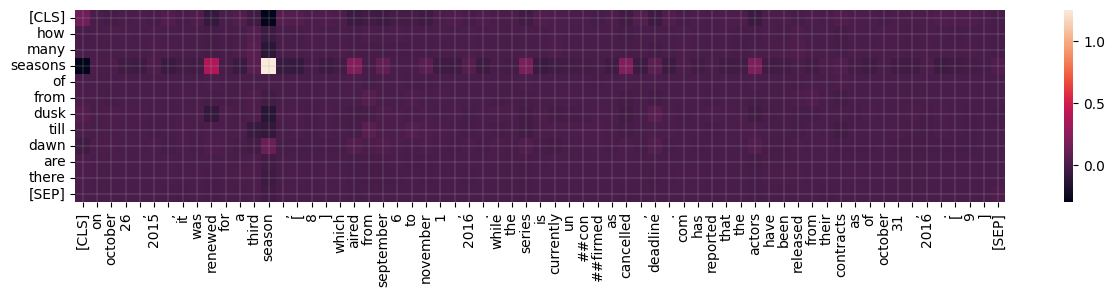

In [36]:
from seaborn import heatmap
import matplotlib.pyplot as plt

with torch.no_grad():
    qd_scores = torch.einsum("id,jd->ij",query_decomposed,doc_decomposed).cpu().numpy()

plt.figure(figsize=(15, 2.5))
heatmap(qd_scores)
plt.xticks(np.arange(len(doc_tokens))+0.5, doc_tokens, rotation='vertical')
plt.yticks(np.arange(len(query_tokens))+0.5, query_tokens, rotation='horizontal')
plt.grid("on", linewidth=0.2)
plt.show()

In [7]:
# CLS ATTN
htmls = [print_importance(norm_heatmap[0], tokenizer.convert_ids_to_tokens(input_ids[0]))]
final_html = html_wrapper(htmls)
display(HTML(final_html))

NameError: name 'norm_heatmap' is not defined

In [18]:
# ALTI dot_scores
htmls = [print_importance(dot_scores, tokenizer.convert_ids_to_tokens(input_ids[0]))]
final_html = html_wrapper(htmls)
display(HTML(final_html))

/tmp/ipykernel_3885204/1364023748.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rgba = matplotlib.cm.get_cmap('Reds')(importance[i] * .7)   # Wistia


Text:


In [40]:
# ALTI dot_scores
htmls = [print_importance(dot_scores, tokenizer.convert_ids_to_tokens(input_ids[0]))]
final_html = html_wrapper(htmls)
display(HTML(final_html))

/tmp/ipykernel_3885204/1364023748.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rgba = matplotlib.cm.get_cmap('Greens')(np.abs(importance[i]) + .5)   # Wistia
/tmp/ipykernel_3885204/1364023748.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rgba = matplotlib.cm.get_cmap('Reds')(importance[i] * .7)   # Wistia


Text:,[CLS] what is non controlling interest on balance sheet [SEP]


<Axes: >

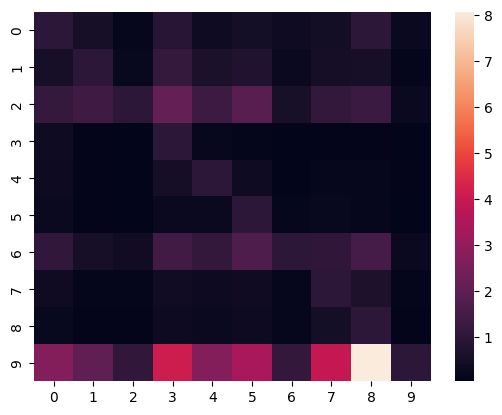

In [38]:
from seaborn import heatmap

norm_heatmap = decompx_last_layer_outputs.aggregated[0][0].norm(dim=-1).cpu().numpy()
heatmap(norm_heatmap / np.diag(norm_heatmap).reshape((-1, 1)))

In [27]:
a = torch.tensor([[1, 1, 1], [2, 2, 2], [3, 3, 3.0]])
a

tensor([[1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.]])

In [30]:
a.mean(dim=0)

tensor([2., 2., 2.])

In [36]:
dot_scores

tensor([-2.9172e-01, -9.6329e-05,  2.1981e-01, -4.0624e-02,  5.8353e-01,
         6.3930e-01, -2.4858e-02, -1.9858e-02,  2.1423e-01, -1.6674e-02,
         1.7603e-01,  2.8427e-01,  5.0068e-03,  2.3846e-02,  5.1403e-03,
         9.2428e-02,  6.2007e-03,  1.6161e-03,  8.8507e-02,  7.6687e-02,
        -1.2168e-02,  1.2525e-03,  1.6509e-01,  1.1297e-02, -3.3251e-02,
        -5.0471e-03,  1.5360e-01, -1.8222e-02, -2.4907e-02,  5.7846e-02,
         1.9507e-02, -1.2699e-02, -1.7708e-02, -6.5968e-02, -2.1487e-02,
        -2.9040e-02,  9.7781e-02,  6.9697e-02, -7.9934e-03, -2.1066e-02,
         4.4278e-02,  1.8740e-02, -2.2339e-02,  1.3859e-02,  2.0237e-04,
        -1.6022e-02, -7.5899e-03,  2.6060e-03, -1.4999e-02,  1.3263e-02,
         4.5005e-02, -2.1850e-02, -2.2879e-02, -2.2805e-02,  7.9057e-03,
        -6.9884e-03,  5.5634e-03, -5.2729e-02,  2.8929e-03,  3.1742e-03,
        -1.2195e-02,  4.1092e-02, -1.5303e-02, -1.9350e-02,  1.3512e-02,
        -3.0296e-02, -1.2062e-02, -1.0398e-02, -3.3